In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/bhl

Mounted at /gdrive
/gdrive/MyDrive/bhl


In [ ]:
def load_data(path, X_column_filter = None):
  import os
  import pandas as pd

  train_path = os.path.join(path, 'train.csv')
  test_path = os.path.join(path, 'test.csv')
  train = pd.read_csv(train_path)
  test = pd.read_csv(test_path)

  cols_to_drop = ['subject'] # ['void()', 'subject']
  train = train.drop(cols_to_drop, axis = 1)
  test = test.drop(cols_to_drop, axis = 1)

  target = 'Activity' #'void()'
  # col_activ = 'Activity'
  # target_id = 'Activity_id'
  # activities = train[col_activ].unique()
  # activ_dict = dict(zip(activities, range(len(activities))))
  # train[target_id] = train[col_activ].map(activ_dict)
  # test[target_id] = test[col_activ].map(activ_dict)
  # test = test.drop(col_activ, axis = 1)
  # train = train.drop(col_activ, axis = 1)

  # train = train[train[target].notna()]
  # test = test[test[target].notna()]
  # train[target] = train[target].astype('int')
  # test[target] = test[target].astype('int')
  
  train_x, train_y = train.drop(target, axis = 1), train[target]
  test_x, test_y = test.drop(target, axis = 1), test[target]

  if X_column_filter:
    train_x = train_x[X_column_filter]
    test_x = test_x[X_column_filter]

  return train_x, train_y.values.ravel(), test_x, test_y.values.ravel()

In [ ]:
def train_xgboost(path, X_column_filter = None):
  from sklearn.metrics import accuracy_score, classification_report
  import xgboost as xgb

  train_x, train_y, test_x, test_y = load_data(path, X_column_filter)

  model = xgb.XGBClassifier()
  model.fit(train_x, train_y)

  y_pred = model.predict(test_x)

  print(f'Using {path} data, model has {accuracy_score(test_y, y_pred)*100} acc')

  return model, y_pred, test_y

In [ ]:
model, y_pred, test_y = train_xgboost('./unbalanced_raw')

Using ./unbalanced_raw data, model has 97.76422764227642 acc


In [ ]:
importances = model.get_booster().get_score(importance_type='gain')
importances_sorted = sorted([(k,v) for k,v in importances.items()], key = lambda x: x[1])


In [ ]:
def sensor_groups(importances_sorted):
  name_dict = {}
  name_list = []
  for imp in importances_sorted:
    name_dict[imp[0]] = imp[1]
    name_list.append(imp[0])

  group_dict = {}
  for name_id in range(len(name_list)):
    firstl = name_list[name_id][:5]
    if firstl not in group_dict.keys():
      group_dict[firstl] = [name_list[name_id]]
    for next_name_id in range(name_id+1, len(name_list)):
      nfirstl = name_list[next_name_id][:5]
      if firstl == nfirstl and name_list[next_name_id] not in group_dict[firstl]:
        group_dict[firstl].append(name_list[next_name_id])
  return group_dict, name_dict

In [ ]:
group_dict, sensor_dict = sensor_groups(importances_sorted)
print (group_dict.keys())

dict_keys(['fBody', 'tBody', 'tGrav', 'energ', 'angle'])


In [ ]:
def statistics_for_groups(groups_dict, sensor_dict):
  stat_dict = {}
  for group_tag in groups_dict.keys():
    print (group_tag)
    sum_val = 0
    min_val = 1000
    max_val = 0
    mean_val = 0
    for importances in groups_dict[group_tag]:
      val = sensor_dict[importances]
      sum_val += val
      if val < min_val:
        min_val = val
      if val > max_val:
        max_val = val
    mean_val = sum_val/len(groups_dict[group_tag])
    stat_dict[group_tag] = (min_val, max_val, sum_val, mean_val, len(groups_dict[group_tag]))
  return stat_dict

In [79]:
stat_dict1 = statistics_for_groups(group_dict, sensor_dict)
stat_dict = {}
for key in stat_dict1.keys():
  if key == 'fBody':
    stat_dict['Body Acceleration (frequency)'] = stat_dict1[key]
  elif key == 'tBody':
    stat_dict['Body Acceleration'] = stat_dict1[key]
  elif key == 'tGrav':
    stat_dict['Gravity Acceleration'] = stat_dict1[key]
  elif key == 'energ':
    stat_dict['energy-mean'] = stat_dict1[key]
  elif key == 'angle':
    stat_dict['angle()'] = stat_dict1[key]

for key in stat_dict.keys():
  print('Sensor group: %s' % key)
  print ('Min in group: %f, max in group: %f, sum of values in group: %f, mean of values in group: %f, Elements in group: %d' % (stat_dict[key][0],stat_dict[key][1],stat_dict[key][2],stat_dict[key][3], stat_dict[key][4]))


fBody
tBody
tGrav
energ
angle
Sensor group: Body Acceleration (frequency)
Min in group: 0.008812, max in group: 410.929779, sum of values in group: 3950.171397, mean of values in group: 22.572408, Elements in group: 175
Sensor group: Body Acceleration
Min in group: 0.021953, max in group: 636.378494, sum of values in group: 3025.131423, mean of values in group: 21.154765, Elements in group: 143
Sensor group: Gravity Acceleration
Min in group: 0.050671, max in group: 162.244234, sum of values in group: 1321.470202, mean of values in group: 31.463576, Elements in group: 42
Sensor group: energy-mean
Min in group: 0.054298, max in group: 0.054298, sum of values in group: 0.054298, mean of values in group: 0.054298, Elements in group: 1
Sensor group: angle()
Min in group: 3.322535, max in group: 88.479849, sum of values in group: 112.693465, mean of values in group: 22.538693, Elements in group: 5


In [75]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt


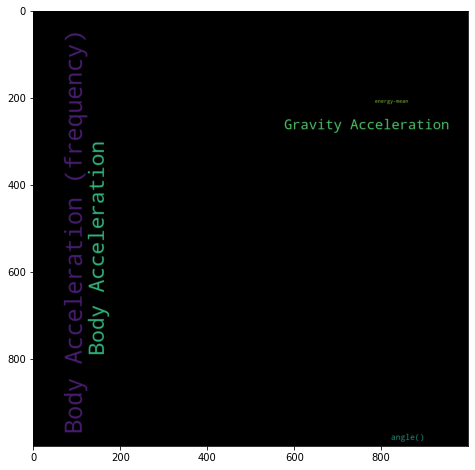

In [76]:
elem_dict = {}
for group in stat_dict.keys():
  elem_dict[group] = stat_dict[group][4]/len(sensor_dict.keys())

from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wc = WordCloud(background_color="black",width=1000,height=1000, max_words=10,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(elem_dict)
plt.figure(figsize=(15,8))
plt.imshow(wc)

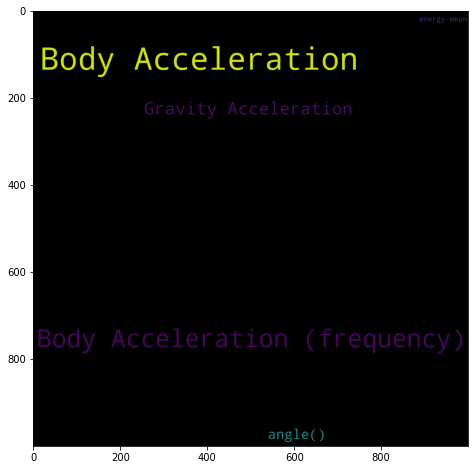

In [77]:
elem_dict = {}
sum_max = 0
for group in stat_dict.keys():
  sum_max += stat_dict[group][1]
for group in stat_dict.keys():
  elem_dict[group] = stat_dict[group][1]/sum_max


wc = WordCloud(background_color="black",width=1000,height=1000, max_words=10,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(elem_dict)
plt.figure(figsize=(15,8))
plt.imshow(wc)

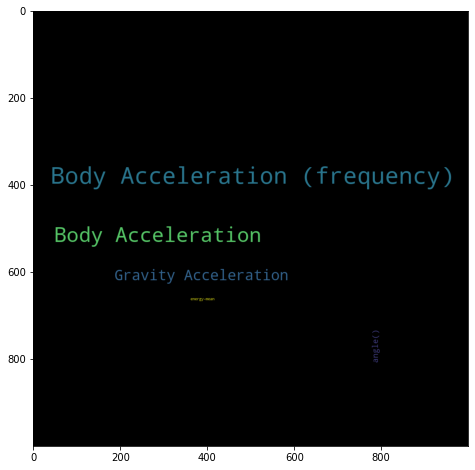

In [80]:
elem_dict = {}
sum_sum = 0
for group in stat_dict.keys():
  sum_sum += stat_dict[group][2]
for group in stat_dict.keys():
  elem_dict[group] = stat_dict[group][2]/sum_sum


wc = WordCloud(background_color="black",width=1000,height=1000, max_words=10,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(elem_dict)
plt.figure(figsize=(15,8))
plt.imshow(wc)

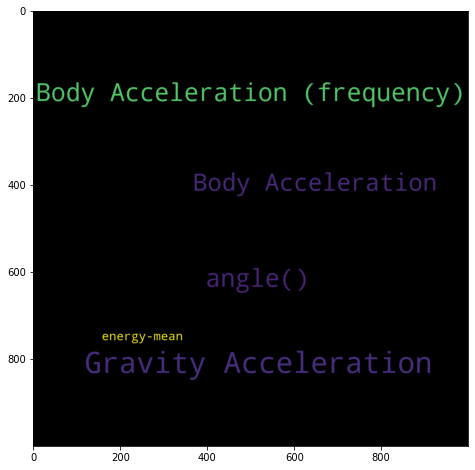

In [81]:
elem_dict = {}
sum_m = 0
for group in stat_dict.keys():
  sum_m += stat_dict[group][3]
for group in stat_dict.keys():
  elem_dict[group] = stat_dict[group][3]/sum_m


wc = WordCloud(background_color="black",width=1000,height=1000, max_words=10,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(elem_dict)
plt.figure(figsize=(15,8))
plt.imshow(wc)

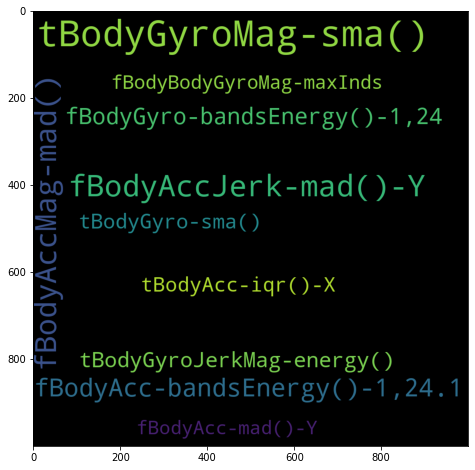

In [ ]:
importances_dict = {}
sum_imp = 0
for imp in importances_sorted:
  sum_m += imp[1]
for imp in importances_sorted:
  importances_dict[imp[0]] = imp[1]/sum_m

wc = WordCloud(background_color="black",width=1000,height=1000, max_words=10,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(importances_dict)
plt.figure(figsize=(15,8))
plt.imshow(wc)

In [ ]:
top50 = [x[0] for x in importances_sorted[-50:]]

In [ ]:
# tried predicting void()
model, y_pred, test_y = train_xgboost('./unbalanced_raw')

Using ./unbalanced_raw data, model has 0.28760162601626016 acc


In [ ]:
model, y_pred, test_y = train_xgboost('./unbalanced_raw', top50)

Using ./unbalanced_raw data, model has 0.9522357723577236 acc


In [ ]:
def plot_cm(test_y, y_pred):
  import numpy as np
  import seaborn as sns
  import pandas as pd
  from sklearn import metrics
  labels = sorted(np.unique(test_y))
  cm = metrics.confusion_matrix(test_y, y_pred)
  df = pd.DataFrame(cm, index = labels, columns = labels)
  ax = sns.heatmap(df, annot=True, fmt='d')
  ax.set_title('Confusion matrix')
  ax.set_xlabel('True label')
  ax.set_ylabel('Prediction')
  return ax


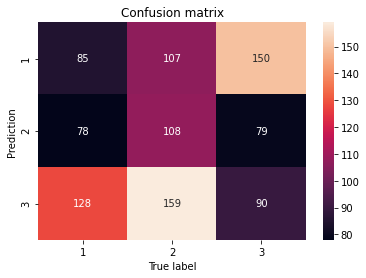

In [ ]:
plot_cm(y_pred, test_y)

In [ ]:
train_xgboost('./unbalanced_raw')
train_xgboost('./unbalanced')
train_xgboost('./balanced')
x = 1